****Сборный проект 2 - Анализ поведения пользователей в мобильном приложении по продаже продуктов питания****

### Описание проекта

В данном проекте я выступаю аналитиком стартапа, у которого есть мобильное приложение по заказу продуктов питания.

Мне необходимо проанализировать поведение пользователей приложения, изучить воронку продаж и интерпритировать результаты А/А/В - теста.

Так же необходимо помнить о первичной и обязательной работе с данными - проверить их качество т.е. провести предобработку.

### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 


- `EventName` — название события;


- `DeviceIDHash` — уникальный идентификатор пользователя;


- `EventTimestamp` — время события;


- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Цель и задачи проекта

Цель проекта - изучить поведение пользователей приложения и сделать выводы по результатам А/В-теста для помощи в принятии бизнесс-решения о смене дизайна приложения. 

Задачи проекта:
1. Изучить данные в логе;


2. Выстроить воронку событий;


3. Выяснить на каком шаге теряется больше всего пользователей;


4. Выяснить сколько пользователей проходит от первого события до оплаты;


5. Изучить пользователей каждой экспрементальной группы;


6. Выяснить есть ли различия в эксперементальных группах;


7. Выяснить как повлияли на пользователей изменения, внесенные в эксперементальную группу.

### План работы

1. Ознакомиться с данными;


2. Выполнить предобработку;


3. Изучить и проверить данные;


4. Изучить воронку событий;


5. Изучить результаты эксперимента;


6. Выводы.

### Загрузка и изучение данных.

In [1]:
# Импортирую необходимые библеотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Выгружаю данные
logs = pd.read_csv('logs_exp.csv', sep='\t')

In [4]:
# Напишу функцию для вывода первичной информации о датасетах - по рекомендации других ревьеров
def describe_dataset(df, name):
    # Устанавливаю максимальную ширину отображаемого текста в колонке до 100 символов
    pd.options.display.max_colwidth = 1000

    print(f"=== {name}: Первые 5 строк ===")
    print(df.head())
    print("\n")
    
    print(f"=== {name}: Последние 5 строк ===")
    print(df.tail())
    print("\n")
    
    print(f"=== {name}: Информация о датасете ===")
    df.info()
    print("\n")
    
# Применю функцию к датасету
describe_dataset(logs, "Logs")

=== Logs: Первые 5 строк ===
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248


=== Logs: Последние 5 строк ===
                 EventName         DeviceIDHash  EventTimestamp  ExpId
244121    MainScreenAppear  4599628364049201812      1565212345    247
244122    MainScreenAppear  5849806612437486590      1565212439    246
244123    MainScreenAppear  5746969938801999050      1565212483    246
244124    MainScreenAppear  5746969938801999050      1565212498    246
244125  OffersScreenAppear  5746969938801999050      1565212517    246


=== Logs: Информация о датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeInde

После вывода предварительной информации о датасете посмотрю колличество дубликатов:

In [5]:
logs.duplicated().sum()

413

#### Предварительные выводы после изучения данных

Я ознакомилась с данными. В датсете `logs` всего 244 126 строк и 4 столбцв. 

Уже на данном этапе видны проблемы, которые необходимо устранить на этапе предобработке данных:

- Некорректное наименование столбцов (не соотвествует snake_case), а также, думаю, изменить названия на более лаконичные и понятные ;


- Некорректные тип данных для столбца `EventTimestamp`;


- Не хватает отдельного столбца только с датой;


- 413 Дубликатов.


Такие проблемы нормальны так как скорее всего в системе сбора данных наименование столбцов указаны в форме удобной для человека (а это названия с большой буквы или слитное написание название ID). Тип данных некорректен в столбцах содержащих даты, вероятно, произошел сбой при выгрузки данных.

В целом, данные пригодны для дальнейшего анализа - нет пропущенных значений, но необходима предобратка.

### Предобработка данных

Приведу столбец с датами к корректному типу:

In [6]:
# Меняю тип
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s')

In [7]:
# Выполняю проверку
logs.dtypes

EventName                 object
DeviceIDHash               int64
EventTimestamp    datetime64[ns]
ExpId                      int64
dtype: object

Отлично, тип корректный.


Теперь создам столбец, содержащий только дату:

In [8]:
logs['event_date'] = logs['EventTimestamp'].dt.date
logs['event_date'] = pd.to_datetime(logs['event_date'])

In [9]:
# Выполняю проверку
logs.dtypes

EventName                 object
DeviceIDHash               int64
EventTimestamp    datetime64[ns]
ExpId                      int64
event_date        datetime64[ns]
dtype: object

Теперь изменю наименования столбцов:

In [10]:
logs.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_time',
    'ExpId': 'group_type'
}, inplace=True)

In [11]:
# Выполняю проверку
logs.columns

Index(['event_name', 'device_id', 'event_time', 'group_type', 'event_date'], dtype='object')

Отлично, у всех столбцов корректные и понятные наименования.

Теперь удалю дубликату, проверю сколько данных потеряется после удаления и выполню проверку:

In [12]:
# Исходное количество записей
total_count = logs.shape[0]

# Удаление дубликатов
logs = logs.drop_duplicates().reset_index(drop=True)

# Количество записей после удаления дубликатов
final_count = logs.shape[0]

# Расчет процента потерянных данных
data_loss = ((total_count - final_count) / total_count) * 100

print(f"Дубликатов после удаления: {logs.duplicated().sum()}")
print(f"Процент потери данных после удаления дубликатов: {data_loss:.2f}%")

Дубликатов после удаления: 0
Процент потери данных после удаления дубликатов: 0.17%


Отлично, дубликаты удалены. Удалили менее одного процента данных, что не сущетвенно для дальнейшего анализа.

#### Вывод по предобработке данных

На данном этапе данные готовы к дальнейшей работе:

- Данные приведены к корректному типу, где это необходимо;


- Добавлен столбец с датой без времени для удобства последующего анализа;


- Изменены наименования столбцов в соотвествии с общепринятым и удобным для работы стилем, а так же со смысловым содержанием;


- Удалены дубликаты. Проведина проверка на уместность потери данных;



- Сделаны выводы о причине проблем в данных.

###  Изучение и проверка данных

****На данном этапе необходимо:****

1. Узнать колько всего событий в логе;



2. Узнать сколько всего пользователей в логе;



3. Узнать сколько в среднем событий приходится на пользователя;



4. Узнать данными за какой период я располагаю;

    1. Найти максимальную и минимальную дату; 
    
    2. Изучить, как меняется количество данных: построить столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп;
    
    3. Узнать можно ли быть уверенным, что у вас одинаково полные данные за весь период. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»; 
    
    4. Определить, с какого момента данные полные и отбросьте более старые; 
    
    5. Узнать данными за какой период времени я располагаю на самом деле.
    
    
    
5. Узнать много ли событий и пользователей потеряно при отсечении старых данных;



6. Проверить, что у меня есть пользователи из всех трёх экспериментальных групп.

#### Количество событий в логе:

In [13]:
events_count = logs.shape[0]
print(f"Общее количество событий в логе: {events_count}")
print("\n")
print(f"Количество каждого из событий в логе: {logs['event_name'].value_counts()}")

Общее количество событий в логе: 243713


Количество каждого из событий в логе: event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64


#### Количество пользователей в логе:

In [14]:
users_count = logs['device_id'].nunique()
print(f"Количество пользователей в логе: {users_count}")

Количество пользователей в логе: 7551


#### Количество событий на пользователя в логе:

In [15]:
events_per_user_count = round((events_count / users_count), 2)
print(f"Количество событий на пользователя в логе: {events_per_user_count}")

Количество событий на пользователя в логе: 32.28


#### Период имеющихся данных:

In [16]:
max_date = logs['event_date'].max()
print(f"Максимальная дата: {max_date}")

Максимальная дата: 2019-08-07 00:00:00


In [17]:
min_date = logs['event_date'].min()
print(f"Минимальная дата: {min_date}")

Минимальная дата: 2019-07-25 00:00:00


In [18]:
date_time = max_date - min_date
print(f"Временной промежуток: {date_time}")

Временной промежуток: 13 days 00:00:00


##### Столбчатая диаграмма количество событий в зависимости от времени в разрезе групп

In [19]:
# Группирую данные и подсчитываю количество событий для каждой группы на каждую дату.
# Использую size() для подсчёта размера группы, т.е. количества событий.
# Переименовываю столбец для наглядного вывода.
grouped_logs = logs.groupby(['event_date', 'group_type']).size().reset_index(name='event_count')
grouped_logs

,event_date,group_type,event_count
0,2019-07-25,246,4
1,2019-07-25,247,1
2,2019-07-25,248,4
3,2019-07-26,246,14
4,2019-07-26,247,8
5,2019-07-26,248,9
6,2019-07-27,246,24
7,2019-07-27,247,23
8,2019-07-27,248,8
9,2019-07-28,246,33


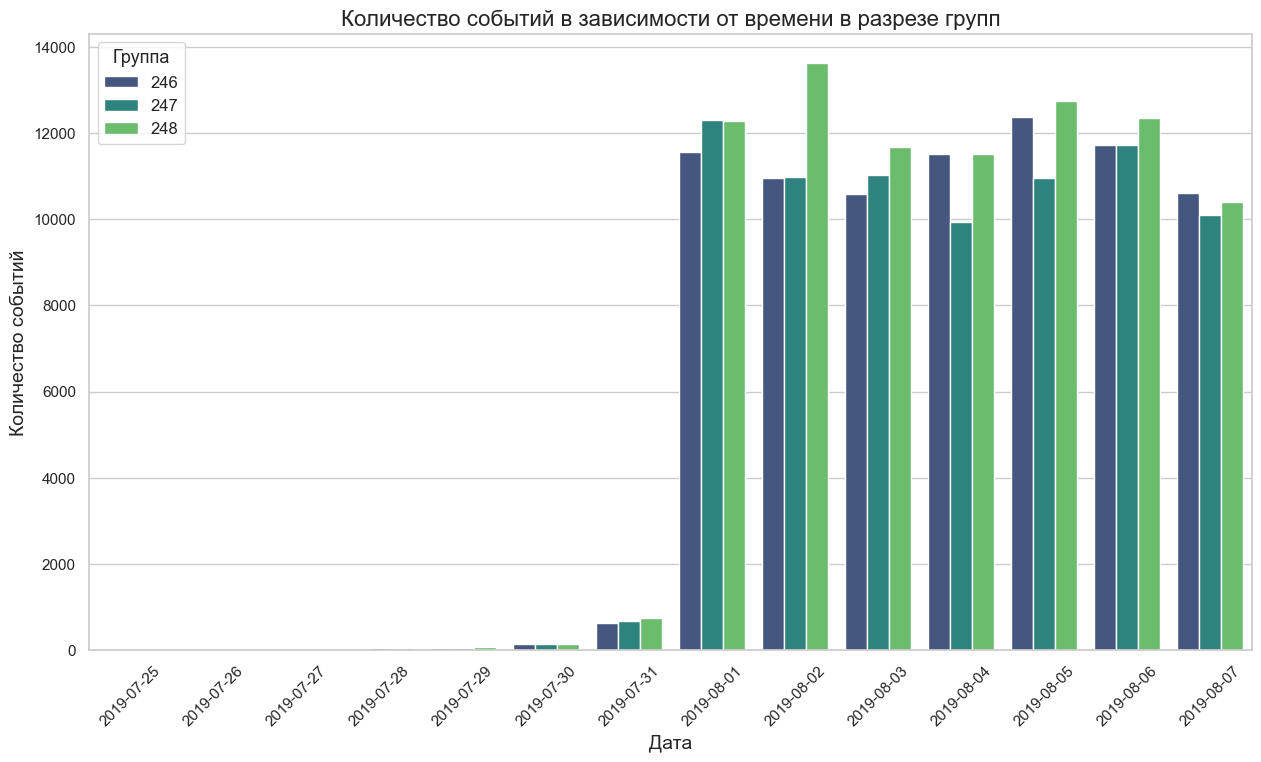

In [20]:
# Перевожу дату в строковый формат для читаемости дат на графике
grouped_logs['event_date'] = grouped_logs['event_date'].dt.strftime('%Y-%m-%d')

# Устанавливаю стиль графика
sns.set(style="whitegrid")

# Создаю столбчатую диаграмму
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(data=grouped_logs, x='event_date', y='event_count', hue='group_type', palette='viridis')

# Делаю метки дат под наклоном для более удобного вывода
plt.xticks(rotation=45)

# Добавляю подписи и заголовок, устанвливаю размер
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество событий', fontsize=14)
plt.title('Количество событий в зависимости от времени в разрезе групп', fontsize=16)

# Подгоняю легенду
plt.legend(title='Группа', title_fontsize='13', fontsize='12')

# Вывожу график
plt.show()

***Выводы по графику:***

В начале виден относительно медленный рост количества событий во всех трёх группах.
Существенное увеличение количества событий начинается с 1 августа и продолжается в течение первых дней месяца. 
Самые высокие значения количества событий для всех групп наблюдаются в период с 01.08 по 07.08, с небольшим спадом к 7 августа. Это указывает на высокую активность пользователей в приложении в этот период.
Группа 248 (эксперментальная) часто показывает наибольшее количество событий, особенно во второй половине рассматриваемого периода. Это может свидетельствовать о том, что изменения, применённые в этой группе, могли положительно повлиять на активность пользователей.

##### Полнота данных за весь период. 
Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

Для того, чтобы быть уверенным, что данные одинаково полные за весь период необходимо: 

1. Построить график, показывающий количество событий каждый день. Это даст представление о том, как изменялась активность пользователей и были ли дни с необычно низким или высоким количеством событий, что может указывать на проблемы данных.


2. Построить график времени появления записей в логе, который может помочь выявить задержки. Например, если много событий за предыдущий день регистрируются после полуночи следующего дня, это может указывать на проблемы с задержкой данных.

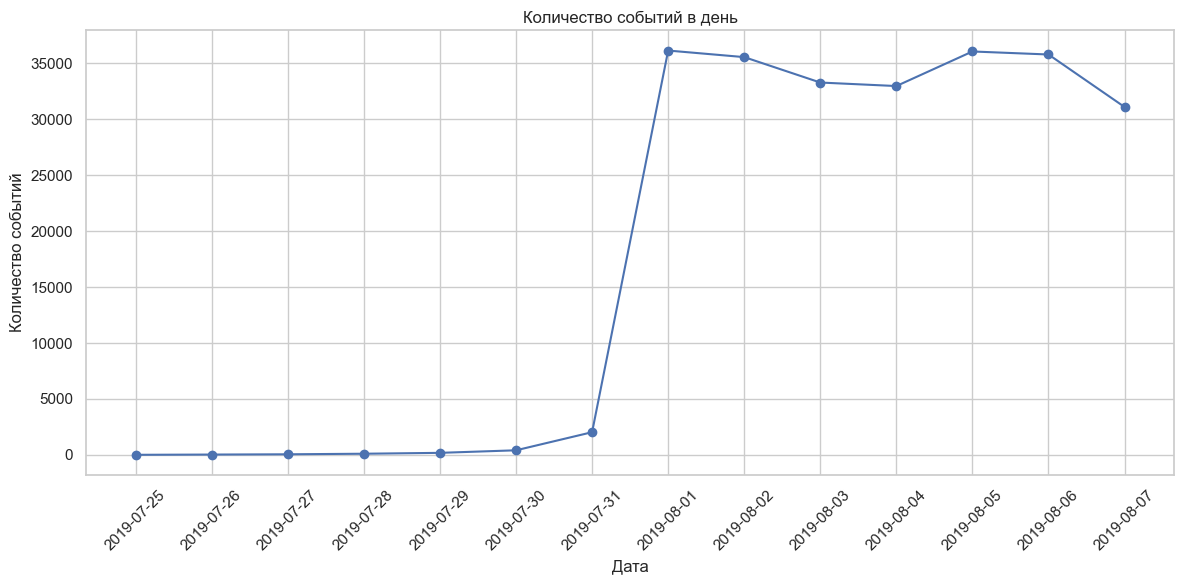

In [21]:
# Группировка данных по дате
daily_events = grouped_logs.groupby('event_date')['event_count'].sum()

# Визуализация количества событий по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_events.index, daily_events.values, marker='o', linestyle='-')
plt.title('Количество событий в день')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

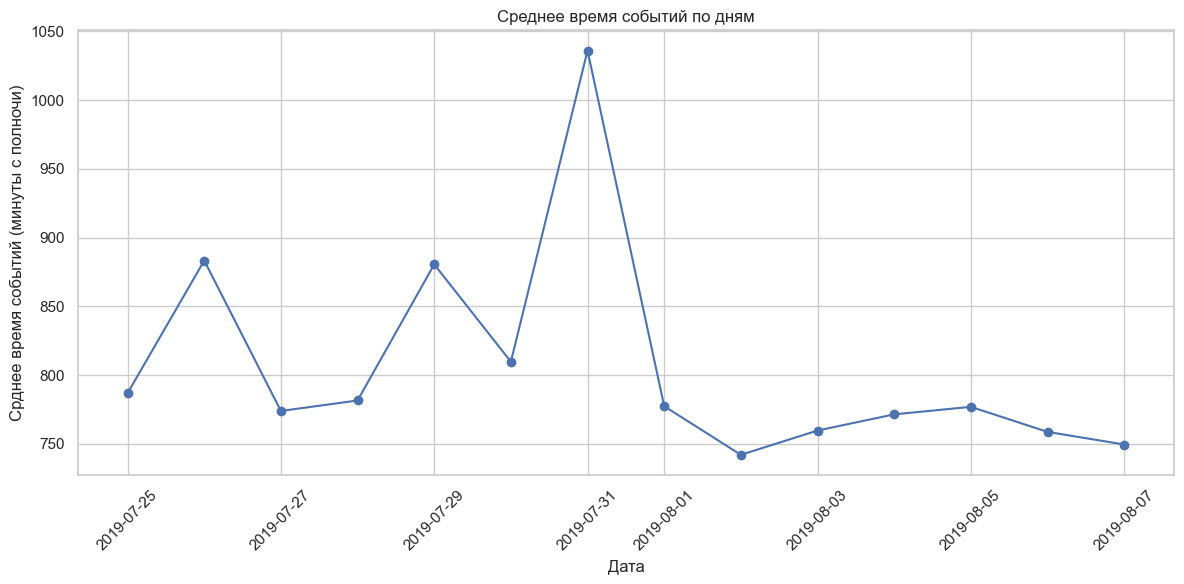

In [22]:
# Вычисление времени событий относительно начала дня
logs['time_of_day'] = logs['event_time'].dt.hour * 60 + logs['event_time'].dt.minute

# Группировка данных по дате и расчет среднего времени событий
average_time_of_day = logs.groupby('event_date')['time_of_day'].mean()

# Визуализация среднего времени событий по дням
plt.figure(figsize=(12, 6))
plt.plot(average_time_of_day.index, average_time_of_day.values, marker='o', linestyle='-')
plt.title('Среднее время событий по дням')
plt.xlabel('Дата')
plt.ylabel('Срднее время событий (минуты с полночи)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

***Выводы по графику***

На графике количества событий видно, что количество событий в день было относительно низким до 31 июля. С 1 августа наблюдается резкое увеличение количества событий. Это может быть связанно с началом периода тестирования. 
На графике среднего времени событий заметны существенные колебания среднего времени событий, особенно резкий пик на 31 июля, когда среднее время событий поднялось до почти 1000 минут (около 16:40). Это указывает на то, что события этого дня могли быть зарегистрированы с задержкой.
После резкого пика времени событий на 31 июля, среднее время событий стабилизируется и держится на уровне около 800 минут (примерно 13:20).

##### Определение периода полных данных и фильтрация неактуальных данных

Благодаря построенным ранее графикам, можно заметить, что данные за июль показывают заметно меньшее количество событий, что может указывать на неполноту данных за этот период. Резкий рост числа событий начинается с 1 августа, что также может быть связано с началом полноценного логирования данных.

Уберу данные за июлю и построю графики событий по дням и группам, а также график событий по дням

In [23]:
# Фильтрация данных
filtered_logs = logs[logs['event_date'] >= '2019-08-01']
filtered_logs

,event_name,device_id,event_time,group_type,event_date,time_of_day
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,7
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,8
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,8
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,8
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,8
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,1272
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,1273
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,1274
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,1274


In [24]:
# Подсчитаю сколько данных я потреяла после фильтрации

events_count_after = filtered_logs.shape[0]

# Вычисление потерянных данных
events_loss = events_count - events_count_after
events_loss_percentage = ((events_count - events_count_after) / events_count) * 100

print(f"Количество событий до фильтрации: {events_count}")
print(f"Количество событий после фильтрации: {events_count_after}")
print(f"Количество потерянных данных: {events_loss}")
print(f"Процент потерянных данных: {events_loss_percentage:.2f}%")

Количество событий до фильтрации: 243713
Количество событий после фильтрации: 240887
Количество потерянных данных: 2826
Процент потерянных данных: 1.16%


Отлично, после фильтрации я потреяла менее 2% процентов данных, что не критично для дальнейшего анализа.

Снова построю графики, но после фильтрации

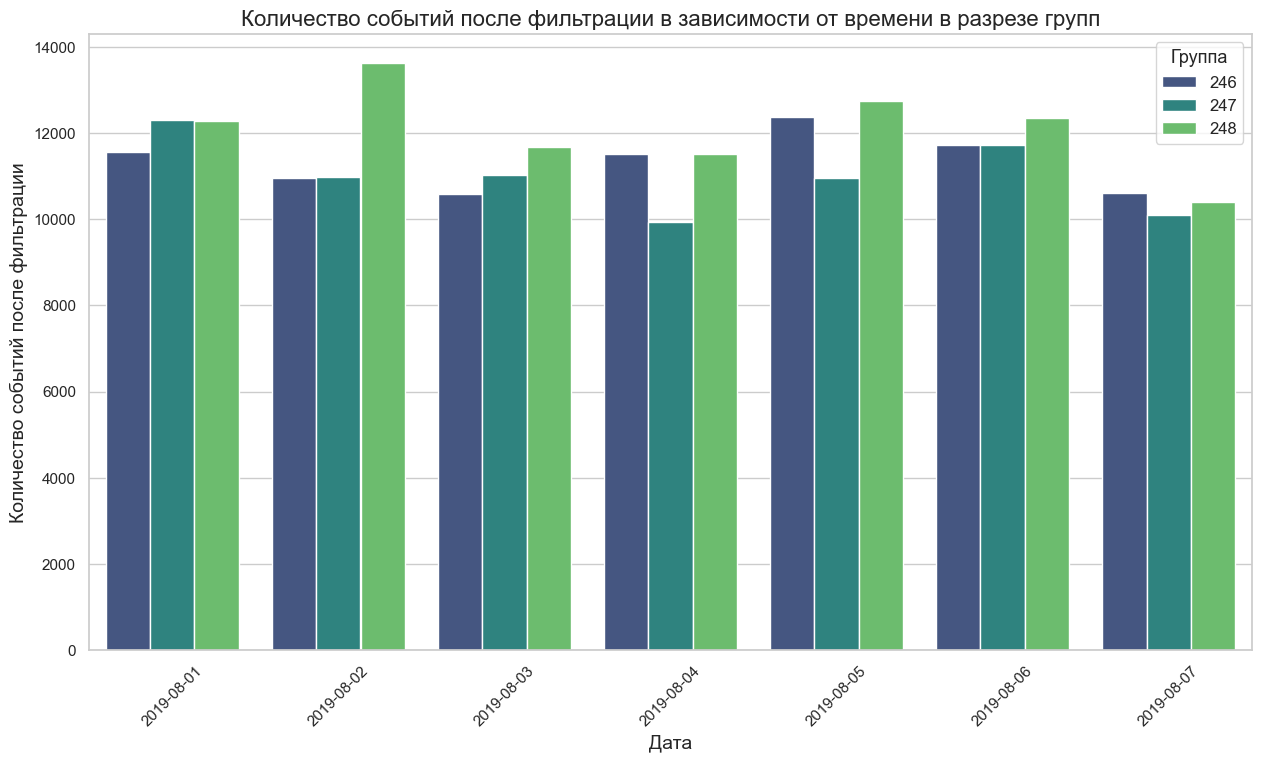

In [25]:
grouped_filtered_logs = filtered_logs.groupby(['event_date', 'group_type']).size().reset_index(name='event_count')

# Перевожу дату в строковый формат для читаемости дат на графике
grouped_filtered_logs['event_date'] = grouped_filtered_logs['event_date'].dt.strftime('%Y-%m-%d')

# Устанавливаю стиль графика
sns.set(style="whitegrid")

# Создаю столбчатую диаграмму
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(data=grouped_filtered_logs, x='event_date', y='event_count', hue='group_type', palette='viridis')

# Делаю метки дат под наклоном для более удобного вывода
plt.xticks(rotation=45)

# Добавляю подписи и заголовок, устанвливаю размер
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество событий после фильтрации', fontsize=14)
plt.title('Количество событий после фильтрации в зависимости от времени в разрезе групп', fontsize=16)

# Подгоняю легенду
plt.legend(title='Группа', title_fontsize='13', fontsize='12')

# Вывожу график
plt.show()

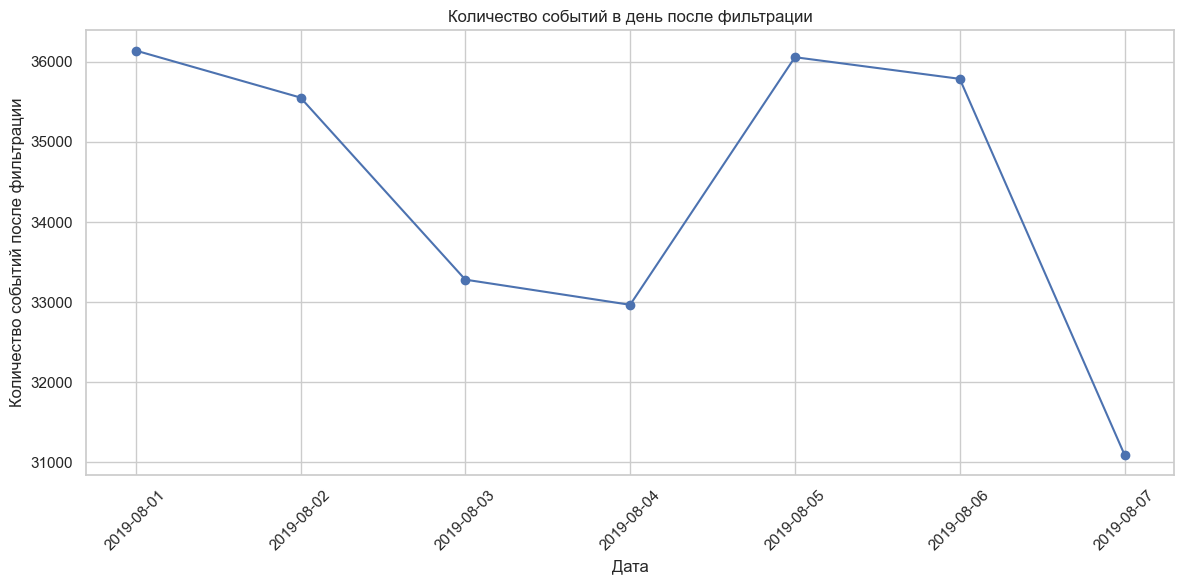

In [26]:
# Группировка данных по дате
daily_events_filtered = grouped_filtered_logs.groupby('event_date')['event_count'].sum()

# Визуализация количества событий по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_events_filtered.index, daily_events_filtered.values, marker='o', linestyle='-')
plt.title('Количество событий в день после фильтрации')
plt.xlabel('Дата')
plt.ylabel('Количество событий после фильтрации')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

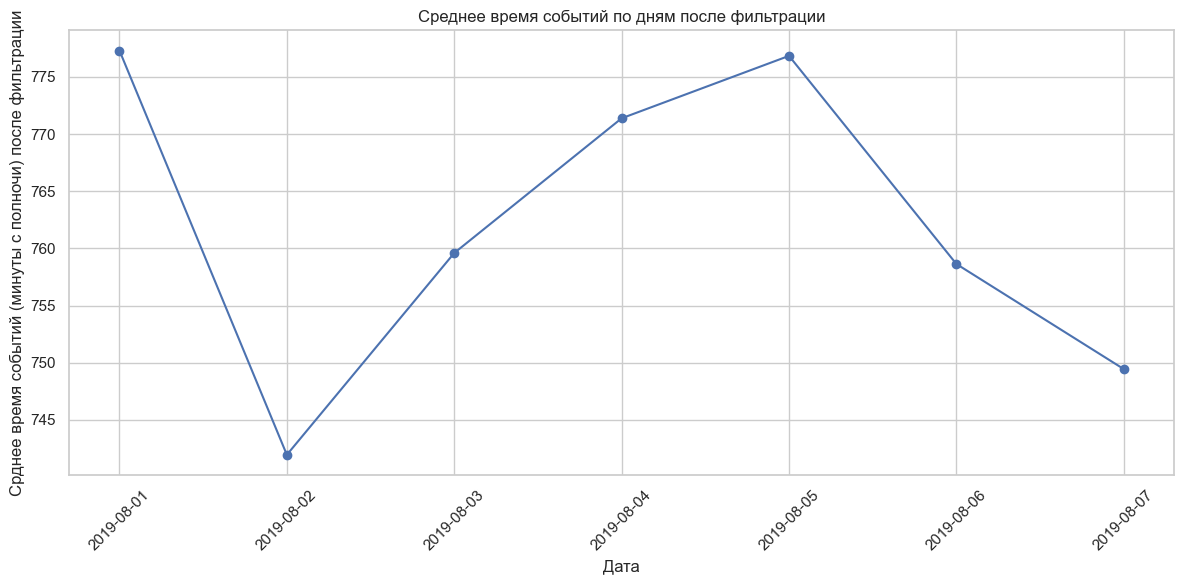

In [27]:

# Группировка данных по дате и расчет среднего времени событий
average_time_of_day = filtered_logs.groupby('event_date')['time_of_day'].mean()

# Визуализация среднего времени событий по дням
plt.figure(figsize=(12, 6))
plt.plot(average_time_of_day.index, average_time_of_day.values, marker='o', linestyle='-')
plt.title('Среднее время событий по дням после фильтрации')
plt.xlabel('Дата')
plt.ylabel('Срднее время событий (минуты с полночи) после фильтрации')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

***Выводы по графикам***

График количества событий после фильтрации в зависимости от времени и групп показывает стабильное количество событий в каждой из трёх групп (246, 247, 248) на протяжении всего анализируемого периода. Это свидетельствует о том, что каждая группа была равномерно активна, и данные в каждой группе полны и сопоставимы. Не наблюдается значительных падений или всплесков, которые могли бы указывать на технические проблемы с логированием данных.



График количества событий в день после фильтрации показывает более стабильное и последовательное количество событий в день с небольшими колебаниями, что характеризует нормальную динамику активности пользователей. Нет значительных просадок, что подтверждает, что проблемы с неполными данными до 1 августа были успешно устранены.



График среднего времени событий за день показывает, что большинство событий происходило примерно в одно и то же время, с небольшими колебаниями. Это может свидетельствовать о стабильной работе системы без задержек в логировании данных.
Пик 5 августа: Есть заметный пик 5 августа, когда среднее время событий увеличивается. Это может указывать на то, что в этот день события регистрировались позднее по каким-то причинам.


Таким образом удаление старых данных помогло исключить период с потенциально неполными или некорректными данными, что сделало анализ более надёжным.

##### Реальный период имеющихся данных

In [28]:
max_date_filtered = filtered_logs['event_date'].max()
min_date_filtered = filtered_logs['event_date'].min()
date_time_filtered = max_date_filtered - min_date_filtered

print(f"Максимальная дата после фильтрации: {max_date_filtered}")
print(f"Минимальная дата после фильтрации: {min_date_filtered}")
print(f"Временной промежуток после фильтрации: {date_time_filtered}")
print(f"Потеря в днях: {date_time - date_time_filtered}")

Максимальная дата после фильтрации: 2019-08-07 00:00:00
Минимальная дата после фильтрации: 2019-08-01 00:00:00
Временной промежуток после фильтрации: 6 days 00:00:00
Потеря в днях: 7 days 00:00:00


Фактически я обладаю полными данными за 6 дней. Потеря данных в днях - 7.

#### Потеря данных в событиях и пользователях

In [29]:
# Подсчет пользователй после фильтрации
users_count_after = filtered_logs['device_id'].nunique()

# Вычисление разницы в количестве пользователей
users_loss = users_count - users_count_after

# Вычисление процента потерянных данных
users_loss_percentage = ((users_count - users_count_after) / users_count) * 100

# Вывод результатов
print(f"Количество событий до фильтрации: {events_count}")
print(f"Количество событий после фильтрации: {events_count_after}")
print(f"Потеряно событий: {events_loss} ({events_loss_percentage:.2f}%)")

print(f"Количество пользователей до фильтрации: {users_count}")
print(f"Количество пользователей после фильтрации: {users_count_after}")
print(f"Потеряно пользователей: {users_loss} ({users_loss_percentage:.2f}%)")

Количество событий до фильтрации: 243713
Количество событий после фильтрации: 240887
Потеряно событий: 2826 (1.16%)
Количество пользователей до фильтрации: 7551
Количество пользователей после фильтрации: 7534
Потеряно пользователей: 17 (0.23%)


***Вывод***

После удаления старых данных потрея пользователй составила менее 1%, потеря событий составила менее 2%, что является минимальной и незначительной потерей для анализа. 

#### Проверка наличия пользователей из всех трёх экспериментальных групп.

In [30]:
# Группировка данных по группе и подсчет уникальных пользователей в каждой группе
users_per_group = filtered_logs.groupby('group_type')['device_id'].nunique()
print(f"Количество пользователей в каждой группе: {users_per_group}")

Количество пользователей в каждой группе: group_type
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


***Вывод***

В данных присутствуют пользователи из всех трёх экспериментальных групп, что позволяет проводить дальнейший анализ. Количество пользователей в группах достаточно сравнимо, что также позволяет проводить дальнейший анализ.

### Изучение воронки событий

****На данном этапе необходимо:****

1. Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте;


2. Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие;


3. Предположить, в каком порядке происходят события. Понять все ли они выстраиваются в последовательную цепочку. Их не нужно учитывать при расчёте воронки;


4. По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B;


5. Узнать на каком шаге теряете больше всего пользователе;


6. Узнать какая доля пользователей доходит от первого события до оплаты.

#### События в логах и их частота

In [31]:
# Считаю количество каждого события
events = filtered_logs['event_name'].value_counts().reset_index()
events.columns = ['name', 'count']
events

,name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


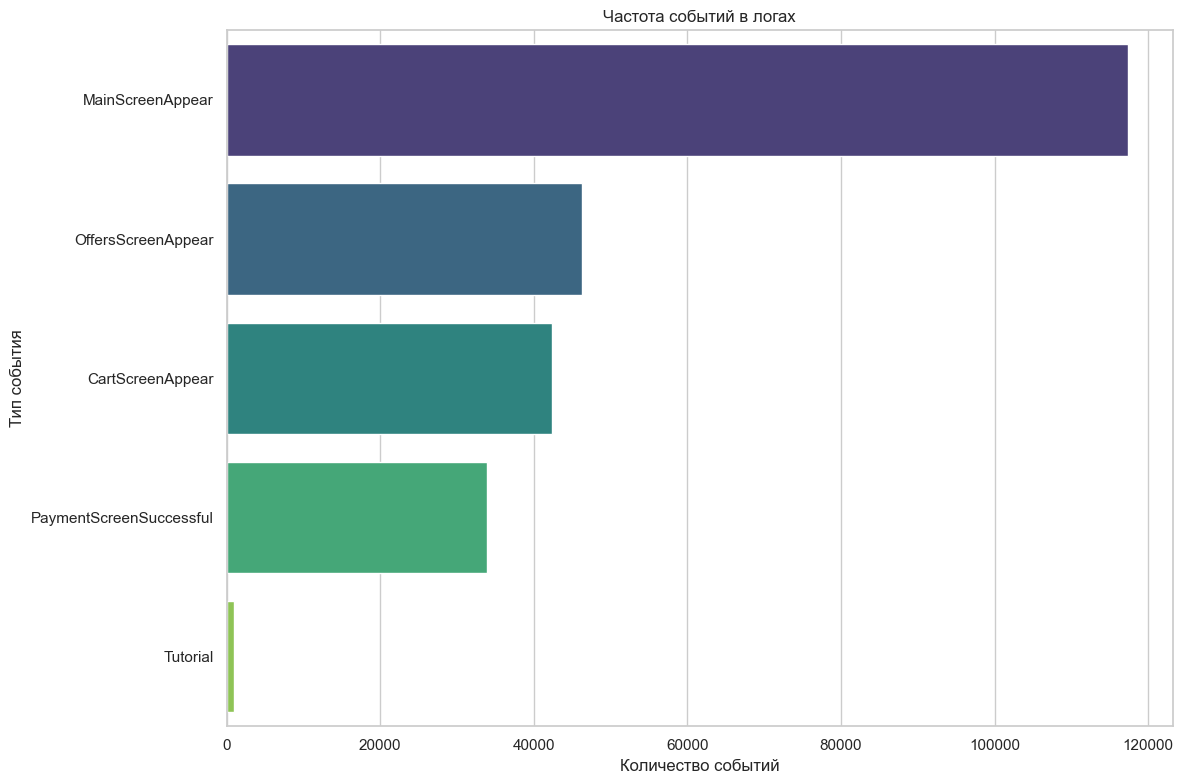

In [32]:
# Строю график частоты событий
plt.figure(figsize=(12, 8))
sns.barplot(data=events, x='count', y='name', palette='viridis')
plt.xlabel('Количество событий')
plt.ylabel('Тип события')
plt.title('Частота событий в логах')
plt.tight_layout()
plt.show()

***Вывод***

Основные экраны (главный экран, экран предложений, экран корзины) и процесс оплаты являются наиболее посещаемыми и используемыми функциями приложения.
Обучение используется реже всего, что может указывать на интуитивно понятный интерфейс или на то, что пользователи пропускают обучение.

#### Количество пользователей совершивших каждое событие. 
Необходимо отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.

In [33]:
# Считаю количество пользователей, совершивших каждое событие
user_event_counts = filtered_logs.groupby('event_name')['device_id'].nunique().reset_index()
user_event_counts.columns = ['event_name', 'user_count']

# Добавляю столбца с долей пользователей
user_event_counts['user_share'] = round((user_event_counts['user_count'] / users_count_after), 2)

# Сортирую событий по числу пользователей
user_event_counts = user_event_counts.sort_values(by='user_count', ascending=False)
user_event_counts

,event_name,user_count,user_share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


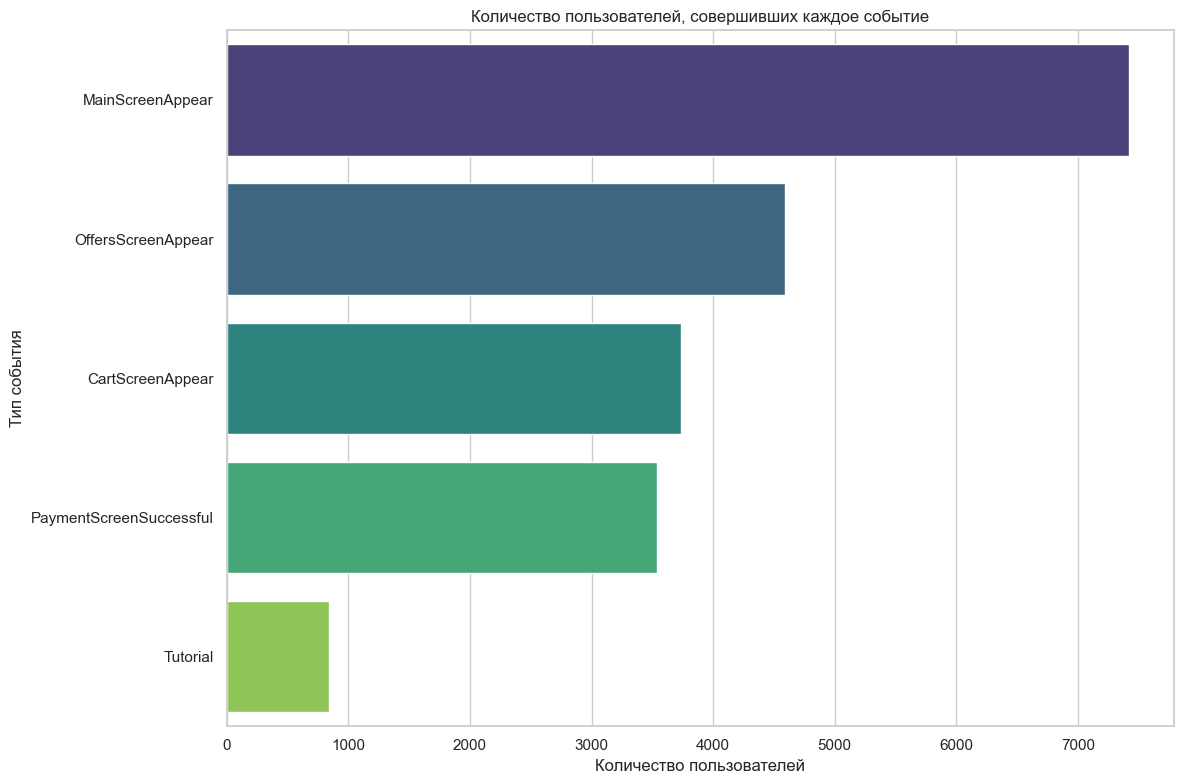

In [34]:
# Строю графика
plt.figure(figsize=(12, 8))
sns.barplot(data=user_event_counts, x='user_count', y='event_name', palette='viridis')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип события')
plt.title('Количество пользователей, совершивших каждое событие')
plt.tight_layout()
plt.show()

***Выводы***

Большая часть пользователей проходит экран главной страницы (более 7 000), но , возможно, перход на главную страницу не первостепенен. Самый большой разрыв по количеству пользователей, совершивших событие  - между главной страницей и страницей предложений (каталогом) - почти 40% пользователей туда не переходят. Но на следующих шагах отсеивается всего 19% и 5% пользователей соответветственно.

#### Порядок событий.
Необходимо понять все ли события выстраиваются в последовательную цепочку. Их не нужно учитывать при расчёте воронки.

Для предположения порядка, в котором происходят события, и понимания, выстраиваются ли они в последовательную цепочку, можно рассмотреть логический путь пользователя через приложение. Обычно пользователи проходят через несколько ключевых этапов в приложении для покупки:


1. MainScreenAppear


2. OffersScreenAppear


3. CartScreenAppear


4. PaymentScreenSuccessful


5. Tutorial

Событие Tutorial не обязательно учитывать , так как оно может происходить в любое время и не является обязательным для совершения покупки.

In [35]:
# Фильтрация данных по уникальному идентификатору пользователя и времени события
filtered_logs = filtered_logs.sort_values(by=['device_id', 'event_time'])

# Добавление столбца с предыдущим событием для каждого пользователя
filtered_logs['prev_event'] = filtered_logs.groupby('device_id')['event_name'].shift(1)

# Подсчет переходов между событиями
transitions = filtered_logs.groupby(['prev_event', 'event_name']).size().reset_index(name='count')

# Вывод результатов
transitions.sort_values(by='count', ascending=False)

,prev_event,event_name,count
6,MainScreenAppear,MainScreenAppear,80323
15,PaymentScreenSuccessful,CartScreenAppear,23984
7,MainScreenAppear,OffersScreenAppear,20179
3,CartScreenAppear,PaymentScreenSuccessful,19819
11,OffersScreenAppear,MainScreenAppear,17443
12,OffersScreenAppear,OffersScreenAppear,16690
1,CartScreenAppear,MainScreenAppear,8341
0,CartScreenAppear,CartScreenAppear,7129
5,MainScreenAppear,CartScreenAppear,6704
2,CartScreenAppear,OffersScreenAppear,6462


***Вывод***

Часто пользователи возвращаются на тот же экран (например, MainScreenAppear to MainScreenAppear), что может свидетельствовать о повторных посещениях или обновлениях экрана.
Наиболее частые переходы включают переходы от главного экрана к другим ключевым экранам (предложения, корзина, успешная оплата), что соответствует ожидаемому пути пользователя через приложение. Наименее популярные переходы связаны с событием Tutorial.

Обновленный порядок событий:


1. MainScreenAppear


2. OffersScreenAppear


3. CartScreenAppear


4. PaymentScreenSuccessful

#### Доля пользователей проходящих на следующий шаг воронки (от числа пользователей на предыдущем). 
То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B

In [36]:
# Считаю количество уникальных пользователей на каждом этапе воронки
funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
funnel = {}

for step in funnel_steps:
    funnel[step] = filtered_logs[filtered_logs['event_name'] == step]['device_id'].nunique()

# Вычисляю доли пользователей, проходящих на следующий шаг
conversion_rates = {}

for i in range(len(funnel_steps) - 1):
    current_step = funnel_steps[i]
    next_step = funnel_steps[i + 1]
    conversion_rates[f"{current_step} на {next_step}"] = funnel[next_step] / funnel[current_step]

# Вывод результата
 
print("\nДоля пользователей, перешедших с \n")
for transition, rate in conversion_rates.items():
    print(f"{transition}: {rate:.2%}")

print("\nКоличество уникальных пользователей на каждом этапе:\n")
for step, count in funnel.items():
    print(f"{step}: {count} пользователей")



Доля пользователей, перешедших с 

MainScreenAppear на OffersScreenAppear: 61.91%
OffersScreenAppear на CartScreenAppear: 81.30%
CartScreenAppear на PaymentScreenSuccessful: 94.78%

Количество уникальных пользователей на каждом этапе:

MainScreenAppear: 7419 пользователей
OffersScreenAppear: 4593 пользователей
CartScreenAppear: 3734 пользователей
PaymentScreenSuccessful: 3539 пользователей


***Вывод***

Почти две трети пользователей, посетивших главный экран, переходят к экрану предложений. Это хороший показатель, который указывает на то, что пользователи заинтересованы в предложениях и акциях. 
Большая часть пользователей, просмотревших предложения, добавляют товары в корзину. 
Почти все пользователи, которые добавили товары в корзину, завершают покупку. 94% очень высокий показатель конверсии.

#### Потеря пользователей на шаге.

In [37]:
# Вычисляю потерю пользователей на каждом шаге
losses = {}
for i in range(len(funnel_steps) - 1):
    current_step = funnel_steps[i]
    next_step = funnel_steps[i + 1]
    losses[f"{current_step} на {next_step}"] = funnel[current_step] - funnel[next_step]

# Определяю шага с наибольшими потерями
max_loss_step = max(losses, key=losses.get)
max_loss_value = losses[max_loss_step]

# Вывод результатов
print("Потеря пользователей на каждом шаге:\n")
for step, loss in losses.items():
    print(f"{step}: потеряно {loss} пользователей")

print(f"\nНаибольшие потери пользователей на шаге: {max_loss_step} - {max_loss_value} пользователей")

Потеря пользователей на каждом шаге:

MainScreenAppear на OffersScreenAppear: потеряно 2826 пользователей
OffersScreenAppear на CartScreenAppear: потеряно 859 пользователей
CartScreenAppear на PaymentScreenSuccessful: потеряно 195 пользователей

Наибольшие потери пользователей на шаге: MainScreenAppear на OffersScreenAppear - 2826 пользователей


***Вывод***

Большего всего пользователей теряется при перехое с главной страницы на страницу предложений - более 2 800.

#### Доля пользователей перходящих от первого события до оплаты.

In [38]:
print(f"Доля пользователей, дошедших от первого события до оплаты: {(funnel['PaymentScreenSuccessful'] / funnel['MainScreenAppear']) * 100:.2f}%")

Доля пользователей, дошедших от первого события до оплаты: 47.70%


Почти половина пользователей (более 47%) проходят весь путь от первого взаимодействия с приложением (главный экран) до успешной оплаты. Это довольно хороший показатель, который свидетельствует о том, что значительная часть пользователей успешно выполняет все необходимые шаги для совершения покупки.

### Изучение результатов эксперимента

****На данном этапе необходимо:****

1. Количество пользоватлей в каждой экспериментальной группе;


2. Проверить, находят ли статистические критерии разницу между выборками 246 и 247. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов;


3. Выберите самое популярное событие:
    1. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп;
    2. Посчитать долю пользователей, совершивших это событие;
    3. Проверить, будет ли отличие между группами статистически достоверным;
    4. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию);
    5. Узнать работает ли корректно разбиение на группы;


4. Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Выводы из экспремента;


5. Какой уровень значимости я выбрала при проверке статистических гипотез выше. Посчитать, сколько проверок статистических гипотез я сделала. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если я хочу изменить его, проделать предыдущие пункты и проверьте свои выводы.

#### Количество пользоватлей в каждой группе

In [39]:
print(f"Количество пользователей в каждой группе: {users_per_group}")

Количество пользователей в каждой группе: group_type
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


#### Статистическая разница между группами 246 и 247

Для чтобы проверить корректность всех механизмов необходимо провести А/А-тест групп 246 и 247.


***Критерии успешного A/A-теста:*** 
- Количество пользователей в различных группах различается не более, чем на 1%;


- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;


- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;


- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [40]:
# Выделею данные для контрольных групп 246 и 247
group_246 = filtered_logs[filtered_logs['group_type'] == 246]
group_247 = filtered_logs[filtered_logs['group_type'] == 247]

In [41]:
# Считаю количества пользователей в каждой группе
users_246 = group_246['device_id'].nunique()
users_247 = group_247['device_id'].nunique()

In [42]:
# Проверяю равенство количества пользователей 
user_difference = abs(users_246 - users_247) # Использую abs(), чтобы расчеты были без учета знака
user_difference_percentage = (user_difference / min(users_246, users_247)) * 100 # В данном случае min() возвращает меньшее из двух значений

# Вывод
print(f"Количество пользователей в группе 246: {users_246}")
print(f"Количество пользователей в группе 247: {users_247}")
print(f"Разница в количестве пользователей: {user_difference} ({user_difference_percentage:.2f}%)")

if user_difference_percentage > 1:
    print("Различие в количестве пользователей превышает 1%.")
else:
    print("Различие в количестве пользователей не превышает 1%.")

Количество пользователей в группе 246: 2484
Количество пользователей в группе 247: 2513
Разница в количестве пользователей: 29 (1.17%)
Различие в количестве пользователей превышает 1%.


In [43]:
# Подсчет количества каждого типа события для обеих групп
event_counts_246 = group_246['event_name'].value_counts().sort_index()
event_counts_247 = group_247['event_name'].value_counts().sort_index()


# Объединение результатов для наглядности
event_counts_comparison = pd.DataFrame({'group_246': event_counts_246, 'group_247': event_counts_247}).fillna(0)
event_counts_comparison

,group_246,group_247
event_name,,
CartScreenAppear,14690,12434
MainScreenAppear,37676,39090
OffersScreenAppear,14767,15179
PaymentScreenSuccessful,11852,9981
Tutorial,317,338


In [44]:
# Сравниваю ключевых метрик - количество событий на пользователя
events_per_user_246 = group_246.groupby('device_id').size()
events_per_user_247 = group_247.groupby('device_id').size()

# Провожу t-тест для независимых выборок
t_stat, p_value = st.ttest_ind(events_per_user_246, events_per_user_247, equal_var=False)

# Вывод 
print(f"p-значение: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между контрольными группами 246 и 247.")
else:
    print("Нет статистически значимых различий между контрольными группами 246 и 247.")

p-значение: 0.4584152588842866
Нет статистически значимых различий между контрольными группами 246 и 247.


In [45]:
# Извлекаю уникальных пользователей для каждой группы и преобразовываю в список
users_246_list = group_246['device_id'].unique().tolist()
users_247_list = group_247['device_id'].unique().tolist()

# с помощью цикла нахожу пересечения между группами
double_users = [user for user in users_246_list if user in users_247_list]

# Вывод
print(f"Количество пользователей, попавших в обе группы: {len(double_users)}")

if len(double_users) > 0:
    print("Есть пользователи, попавшие в обе группы.")
else:
    print("Нет пользователей, попавших в обе группы.")

Количество пользователей, попавших в обе группы: 0
Нет пользователей, попавших в обе группы.


In [46]:
# Выделяю пользователей группы 248
group_248_for_double = filtered_logs[filtered_logs['group_type'] == 248]

In [47]:
users_248_list = group_248_for_double['device_id'].unique().tolist()

double_users_246_248 = [user for user in users_246_list if user in users_248_list]
double_users_247_248 = [user for user in users_247_list if user in users_248_list]
triple_users = [user for user in users_246_list if user in users_247_list and user in users_248_list]


print(f"Количество пользователей, попавших в группы 246 и 248: {len(double_users_246_248)}")

if len(double_users_246_248) > 0:
    print("Есть пользователи, попавшие в группы 246 и 248.")
else:
    print("Нет пользователей, попавших в группы 246 и 248.")
    

print("\n")
print(f"Количество пользователей, попавших в группы 247 и 248: {len(double_users_247_248)}")

if len(double_users_247_248) > 0:
    print("Есть пользователи, попавшие в группы 247 и 248.")
else:
    print("Нет пользователей, попавших в группы 247 и 248.")

    
print("\n")
print(f"Количество пользователей, попавших сразу в три группы: {len(triple_users)}")

if len(triple_users) > 0:
    print("Есть пользователи, попавшие сразу в три группы.")
else:
    print("Нет пользователей, попавших сразу в три группы.")

Количество пользователей, попавших в группы 246 и 248: 0
Нет пользователей, попавших в группы 246 и 248.


Количество пользователей, попавших в группы 247 и 248: 0
Нет пользователей, попавших в группы 247 и 248.


Количество пользователей, попавших сразу в три группы: 0
Нет пользователей, попавших сразу в три группы.


***Вывод***

Хотя различие в количестве пользователей превышает 1%, другие критерии успешного A/A теста выполнены: распределение событий между группами равномерное, нет статистически значимых различий между ключевыми метриками, и нет пересечения пользователей между группами. Это свидетельствует о корректности большинства аспектов A/A теста.

#### Самое популярное событие

##### Популярное событие

In [48]:
# Определяю самого популярного события
# Cоздаю серию, где индексами являются названия событий, а значениями — количество их вхождений. 
# Затем idxmax() находит индекс с максимальным значением
most_pop_event = filtered_logs['event_name'].value_counts().idxmax()
print(f"Самое популярное событие: {most_pop_event}")

Самое популярное событие: MainScreenAppear


#####  Число пользователей, совершивших это событие в каждой из контрольных групп

Фильтрую данные для каждой группы по самому популярному событию и подсчитываю уникальных пользователей, совершивших это событие.

In [49]:
most_pop_event_246 = group_246[group_246['event_name'] == most_pop_event]['device_id'].nunique()
most_pop_event_247 = group_247[group_247['event_name'] == most_pop_event]['device_id'].nunique()
print(f"Число пользователей, совершивших событие '{most_pop_event}' в группе 246: {most_pop_event_246}")
print(f"Число пользователей, совершивших событие '{most_pop_event}' в группе 247: {most_pop_event_247}")

Число пользователей, совершивших событие 'MainScreenAppear' в группе 246: 2450
Число пользователей, совершивших событие 'MainScreenAppear' в группе 247: 2476


#####  Доля пользователей, совершивших это событие в каждой из контрольных групп

In [50]:
share_most_pop_event_246 = most_pop_event_246 / users_246
share_most_pop_event_247 = most_pop_event_247 / users_247


print(f"Доля пользователей, совершивших событие '{most_pop_event}' в группе 246: {share_most_pop_event_246:.2%}")


print(f"Доля пользователей, совершивших событие '{most_pop_event}' в группе 247: {share_most_pop_event_247:.2%}")

Доля пользователей, совершивших событие 'MainScreenAppear' в группе 246: 98.63%
Доля пользователей, совершивших событие 'MainScreenAppear' в группе 247: 98.53%


##### Проверка отличий на статистическую достоверность.

Для проверки использую z-тест для пропорций чтобы проверить есть статистически значимые различия пользователей двух групп, совершивших самое популярное событие.

In [51]:
# Создам numpy массивы содержать количество успешных пользователей и общего числа пользователей.
counts = np.array([most_pop_event_246, most_pop_event_247])
totals = np.array([users_246, users_247])
st, p_value = proportions_ztest(count, totals)

alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между группами 246 и 247.")
else:
    print("Нет статистически значимых различий между группами 246 и 247.")

Нет статистически значимых различий между группами 246 и 247.


##### Создание функции для анализа остальных событий

In [52]:
def analyze_events(event_name, group_1, group_2, group_1_label="Group 1", group_2_label="Group 2"):
    # Считаю число пользователей, совершивших событие в каждой группе
    users_1_event = group_1[group_1['event_name'] == event_name]['device_id'].nunique()
    users_2_event = group_2[group_2['event_name'] == event_name]['device_id'].nunique()
    
    # Считаю общее число пользователей в каждой группе
    total_users_1 = group_1['device_id'].nunique()
    total_users_2 = group_2['device_id'].nunique()
    
    # Вычисляю доли пользователей, совершивших событие в каждой группе
    share_1_event = users_1_event / total_users_1
    share_2_event = users_2_event / total_users_2
    
    counts = np.array([users_1_event, users_2_event])
    totals = np.array([total_users_1, total_users_2])
    
    # Провожу z-тест для пропорций
    stat, p_value = proportions_ztest(counts, totals)
    
    # Вывод результатов
    print(f"Событие: {event_name}")
    print(f"{group_1_label} - Количество пользователей: {users_1_event}, Доля: {share_1_event:.2%}")
    print(f"{group_2_label} - Количество пользователей: {users_2_event}, Доля: {share_2_event:.2%}")
    print(f"p-значение: {p_value:.2f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"Результат: Есть статистически значимые различия между {group_1_label} и {group_2_label}.\n")
    else:
        print(f"Результат: Нет статистически значимых различий между {group_1_label} и {group_2_label}.\n")
    
    return {
        'event_name': event_name,
        'users_1': users_1_event,
        'users_2': users_2_event,
        'share_1': share_1_event,
        'share_2': share_2_event,
        'p_value': p_value
    }

# Получаю список всех уникальных событий
unique_events = filtered_logs['event_name'].unique()


# Применяю функцию к каждому событию
for event in unique_events:
    result = analyze_events(event, group_246, group_247, group_1_label="Группа 246", group_2_label="Группа 247")
    


Событие: MainScreenAppear
Группа 246 - Количество пользователей: 2450, Доля: 98.63%
Группа 247 - Количество пользователей: 2476, Доля: 98.53%
p-значение: 0.76
Результат: Нет статистически значимых различий между Группа 246 и Группа 247.

Событие: PaymentScreenSuccessful
Группа 246 - Количество пользователей: 1200, Доля: 48.31%
Группа 247 - Количество пользователей: 1158, Доля: 46.08%
p-значение: 0.11
Результат: Нет статистически значимых различий между Группа 246 и Группа 247.

Событие: CartScreenAppear
Группа 246 - Количество пользователей: 1266, Доля: 50.97%
Группа 247 - Количество пользователей: 1238, Доля: 49.26%
p-значение: 0.23
Результат: Нет статистически значимых различий между Группа 246 и Группа 247.

Событие: OffersScreenAppear
Группа 246 - Количество пользователей: 1542, Доля: 62.08%
Группа 247 - Количество пользователей: 1520, Доля: 60.49%
p-значение: 0.25
Результат: Нет статистически значимых различий между Группа 246 и Группа 247.

Событие: Tutorial
Группа 246 - Количест

##### Выводы о корректности разбиения на группы

По всем рассмотренным событиям p-значение выше 0.05, что означает отсутствие статистически значимых различий между группами 246 и 247.
Это свидетельствует о том, что разбиение на группы работает корректно для всех рассмотренных событий.

#### Анализ группы с измененным шрифтом
Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Выводы из экспремента

In [53]:
# Создам датафрейм с группой 248
group_248 = filtered_logs[filtered_logs['group_type'] == 248]

Для дальнейшей работы мне также понадобятся данные групп 246 и 247, которые хранят датасеты `group_246` и `group_247`.

Применю функцию `analyze_events()` к парам датасетов `group_246` и `group_248`, `group_247` и `group_248`.

In [54]:
for event in unique_events:
    result = analyze_events(event, group_246, group_248, group_1_label="Группа 246", group_2_label="Группа 248")

Событие: MainScreenAppear
Группа 246 - Количество пользователей: 2450, Доля: 98.63%
Группа 248 - Количество пользователей: 2493, Доля: 98.27%
p-значение: 0.29
Результат: Нет статистически значимых различий между Группа 246 и Группа 248.

Событие: PaymentScreenSuccessful
Группа 246 - Количество пользователей: 1200, Доля: 48.31%
Группа 248 - Количество пользователей: 1181, Доля: 46.55%
p-значение: 0.21
Результат: Нет статистически значимых различий между Группа 246 и Группа 248.

Событие: CartScreenAppear
Группа 246 - Количество пользователей: 1266, Доля: 50.97%
Группа 248 - Количество пользователей: 1230, Доля: 48.48%
p-значение: 0.08
Результат: Нет статистически значимых различий между Группа 246 и Группа 248.

Событие: OffersScreenAppear
Группа 246 - Количество пользователей: 1542, Доля: 62.08%
Группа 248 - Количество пользователей: 1531, Доля: 60.35%
p-значение: 0.21
Результат: Нет статистически значимых различий между Группа 246 и Группа 248.

Событие: Tutorial
Группа 246 - Количест

In [55]:
for event in unique_events:
    result = analyze_events(event, group_247, group_248, group_1_label="Группа 247", group_2_label="Группа 248")

Событие: MainScreenAppear
Группа 247 - Количество пользователей: 2476, Доля: 98.53%
Группа 248 - Количество пользователей: 2493, Доля: 98.27%
p-значение: 0.46
Результат: Нет статистически значимых различий между Группа 247 и Группа 248.

Событие: PaymentScreenSuccessful
Группа 247 - Количество пользователей: 1158, Доля: 46.08%
Группа 248 - Количество пользователей: 1181, Доля: 46.55%
p-значение: 0.74
Результат: Нет статистически значимых различий между Группа 247 и Группа 248.

Событие: CartScreenAppear
Группа 247 - Количество пользователей: 1238, Доля: 49.26%
Группа 248 - Количество пользователей: 1230, Доля: 48.48%
p-значение: 0.58
Результат: Нет статистически значимых различий между Группа 247 и Группа 248.

Событие: OffersScreenAppear
Группа 247 - Количество пользователей: 1520, Доля: 60.49%
Группа 248 - Количество пользователей: 1531, Доля: 60.35%
p-значение: 0.92
Результат: Нет статистически значимых различий между Группа 247 и Группа 248.

Событие: Tutorial
Группа 247 - Количест

Теперь необходимо объединить две контрольные группы и сравнить их с эксперементальной

In [56]:
# Использую метод pd.concat() так как он объединяет строки двух датафреймов без потерь 
# Параметр ignore_index=True сбрасывает индексы, чтобы в новом датафрейме они были уникальными и последовательными
group_combined = pd.concat([group_246, group_247], ignore_index=True)
group_combined

,event_name,device_id,event_time,group_type,event_date,time_of_day,prev_event
0,MainScreenAppear,6888746892508752,2019-08-06 14:06:34,246,2019-08-06,846,NaN
1,MainScreenAppear,6922444491712477,2019-08-04 14:19:33,246,2019-08-04,859,NaN
2,PaymentScreenSuccessful,6922444491712477,2019-08-04 14:19:40,246,2019-08-04,859,MainScreenAppear
3,CartScreenAppear,6922444491712477,2019-08-04 14:19:40,246,2019-08-04,859,PaymentScreenSuccessful
4,MainScreenAppear,6922444491712477,2019-08-04 14:19:40,246,2019-08-04,859,CartScreenAppear
...,...,...,...,...,...,...,...
156319,CartScreenAppear,9206002508877262744,2019-08-07 09:46:01,247,2019-08-07,586,PaymentScreenSuccessful
156320,CartScreenAppear,9206002508877262744,2019-08-07 09:46:20,247,2019-08-07,586,CartScreenAppear
156321,PaymentScreenSuccessful,9206002508877262744,2019-08-07 09:48:45,247,2019-08-07,588,CartScreenAppear
156322,PaymentScreenSuccessful,9206002508877262744,2019-08-07 10:22:08,247,2019-08-07,622,PaymentScreenSuccessful


In [57]:
for event in unique_events:
    result = analyze_events(event, group_combined, group_248, group_1_label="Объедененная группа", group_2_label="Группа 248")

Событие: MainScreenAppear
Объедененная группа - Количество пользователей: 4926, Доля: 98.58%
Группа 248 - Количество пользователей: 2493, Доля: 98.27%
p-значение: 0.29
Результат: Нет статистически значимых различий между Объедененная группа и Группа 248.

Событие: PaymentScreenSuccessful
Объедененная группа - Количество пользователей: 2358, Доля: 47.19%
Группа 248 - Количество пользователей: 1181, Доля: 46.55%
p-значение: 0.60
Результат: Нет статистически значимых различий между Объедененная группа и Группа 248.

Событие: CartScreenAppear
Объедененная группа - Количество пользователей: 2504, Доля: 50.11%
Группа 248 - Количество пользователей: 1230, Доля: 48.48%
p-значение: 0.18
Результат: Нет статистически значимых различий между Объедененная группа и Группа 248.

Событие: OffersScreenAppear
Объедененная группа - Количество пользователей: 3062, Доля: 61.28%
Группа 248 - Количество пользователей: 1531, Доля: 60.35%
p-значение: 0.43
Результат: Нет статистически значимых различий между Об

****Вывод****

Во всех рассмотренных случаях нет статистически значимых различий между контрольными группами (246 и 247) и экспериментальной группой (248).Изменение шрифта в экспериментальной группе (248) не оказало значимого влияния на поведение пользователей по сравнению с контрольными группами.

#### Проверка корректности уровня значимости
Какой уровень значимости я выбрала при проверке статистических гипотез выше. Посчитать, сколько проверок статистических гипотез я сделала. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если я хочу изменить его, проделать предыдущие пункты и проверьте свои выводы.

***Выводы***

В предыдущем пункте при сравнении контрольных групп с экспериментальной группой я провела 15 статистических тестов, используя уровень значимости 0.05. Этот уровень является стандартом в статистических исследованиях и обеспечивает более строгий контроль ошибок первого рода (ложноположительных результатов). Применение уровня значимости 0.1 увеличивает вероятность получения ложноположительных результатов, что может привести к неверным выводам.

Проведение большого количества тестов увеличивает вероятность ошибки первого рода, поэтому важно учитывать корректировки для множественных сравнений или придерживаться более консервативного уровня значимости. В данном случае, использование уровня значимости 0.05 позволяет более надежно интерпретировать результаты, минимизируя вероятность принятия ложных гипотез.

### Общий вывод

В ходе исследования я подготовила данные к анализу, проанализировала воронку событий и сравнила контрольные группы в рамках A/A-теста для проверки корректности разбиения на группы. Затем я сравнила каждую контрольную группу с экспериментальной и также сравнила объединённые контрольные группы. Я проверила статистические различия между группами по каждому событию и проанализировала корректность выбранного уровня значимости. По итогам исследования я определила, что нет статистически значимых различий между группами по каждому событию. Это говорит об отсутствии влияния изменения шрифта на поведение пользователей.

Можно спокойно внедрять новый шрифт, зная, что он не изменит отношение пользователей к приложению. Кроме того, я определила, что больше всего пользователей теряется при переходе с главной страницы на страницу предложений. Это стоит учитывать при внедрении других изменений и принятии различных бизнес-решений.